"""
Build a prediction model that will accurately classify which texts are spam.
"""

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [36]:
text_df = pd.read_csv('E:/pg/bpb/BPB-Publications/Datasets/Case Studies/case_study_2/spam.csv', encoding='latin-1')
text_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [37]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
v1            5572 non-null object
v2            5572 non-null object
Unnamed: 2    50 non-null object
Unnamed: 3    12 non-null object
Unnamed: 4    6 non-null object
dtypes: object(5)
memory usage: 217.7+ KB


In [38]:
text_df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [39]:
text_df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


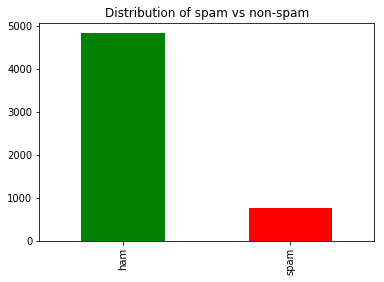

In [40]:
# Distribution of spam/non-spam
count_class = pd.value_counts(text_df["v1"], sort= True)
count_class.plot(kind= 'bar', color= ["green", "red"])
plt.title('Distribution of spam vs non-spam')
plt.show()

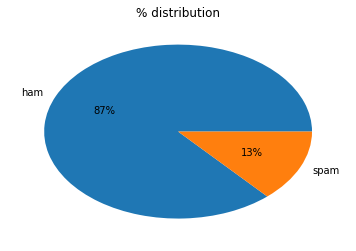

In [41]:
count_class.plot(kind= 'pie', autopct='%1.0f%%')
plt.title('% distribution')
plt.ylabel('')
plt.show()

In [42]:
# find frequencies of words in the spam and non-spam messages
ham_count = Counter(" ".join(text_df[text_df['v1']=='ham']["v2"]).split()).most_common(20)
ham_df = pd.DataFrame.from_dict(ham_count)
ham_df = ham_df.rename(columns={0: "words in non-spam", 1 : "count"})

spam_count = Counter(" ".join(text_df[text_df['v1']=='spam']["v2"]).split()).most_common(20)
spam_df = pd.DataFrame.from_dict(spam_count)
spam_df = spam_df.rename(columns={0: "words in spam", 1 : "count"})

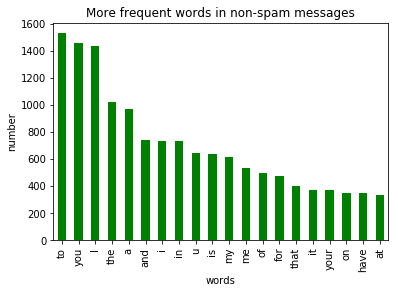

In [43]:
# plot frequency of words in ham
ham_df.plot.bar(legend = False, color = 'green')
y_pos = np.arange(len(ham_df["words in non-spam"]))
plt.xticks(y_pos, ham_df["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

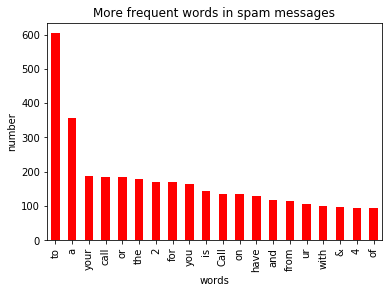

In [44]:
# plot frequency of words in spam
spam_df.plot.bar(legend = False, color = 'red')
y_pos = np.arange(len(spam_df["words in spam"]))
plt.xticks(y_pos, spam_df["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

"""
We can see that the majority of frequent words in both classes are stop words such as 'to', 'a', 'or' and so on.
Stop words refer to the most common words those have very rare or no role in language processing.
"""

In [45]:
# remove the stop words and create new features
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
X = f.fit_transform(text_df["v2"])
np.shape(X)

(5572, 8404)

In [46]:
# transform the variable spam/non-spam into binary variable, then split our data set in training set and test set
text_df["v1"] = text_df["v1"].map({'spam':1,'ham':0})
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, text_df['v1'], test_size=0.33, random_state=42)
print([np.shape(X_train), np.shape(X_test)])

[(3733, 8404), (1839, 8404)]


In [47]:
# train different bayes models changing the regularization parameter
list_alpha = np.arange(1/100000, 20, 0.11)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    count = count + 1

In [48]:
# Let's see some learning models and their metrics
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
                      ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head()

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.998661,0.974443,0.920635,0.895753
1,0.11001,0.997857,0.976074,0.936508,0.893939
2,0.22001,0.997857,0.977162,0.936508,0.900763
3,0.33001,0.997589,0.977162,0.936508,0.900763
4,0.44001,0.997053,0.977162,0.936508,0.900763


In [49]:
# select the model with the most test precision
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

alpha             15.730010
Train Accuracy     0.979641
Test Accuracy      0.969549
Test Recall        0.777778
Test Precision     1.000000
Name: 143, dtype: float64

In [50]:
# see if there is more than one model with 100% precision
models[models['Test Precision']==1].head()

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
143,15.73001,0.979641,0.969549,0.777778,1.0
144,15.84001,0.979641,0.969549,0.777778,1.0
145,15.95001,0.979641,0.969549,0.777778,1.0
146,16.06001,0.979373,0.969549,0.777778,1.0
147,16.17001,0.979373,0.969549,0.777778,1.0


In [51]:
# select which has more test accuracy
best_index = models[models['Test Precision']==1]['Test Accuracy'].idxmax()
bayes = naive_bayes.MultinomialNB(alpha=list_alpha[best_index])
bayes.fit(X_train, y_train)
models.iloc[best_index, :]

alpha             15.730010
Train Accuracy     0.979641
Test Accuracy      0.969549
Test Recall        0.777778
Test Precision     1.000000
Name: 143, dtype: float64

In [52]:
# Confusion matrix with naive bayes classifier
m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'], 
             index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,1587,0
Actual 1,56,196


"""
We misclassify 56 spam messages as non-spam texs whereas we don't misclassify any non-spam message.
"""

In [53]:
# repeat same steps with Support Vector Machine
list_C = np.arange(500, 2000, 100)
score_train = np.zeros(len(list_C))
score_test = np.zeros(len(list_C))
recall_test = np.zeros(len(list_C))
precision_test= np.zeros(len(list_C))
count = 0
for C in list_C:
    svc = svm.SVC(C=C)
    svc.fit(X_train, y_train)
    score_train[count] = svc.score(X_train, y_train)
    score_test[count]= svc.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, svc.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, svc.predict(X_test))
    count = count + 1

In [54]:
matrix = np.matrix(np.c_[list_C, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['C', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head()

,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,500.0,0.994910,0.982599,0.873016,1.0
1,600.0,0.995982,0.982599,0.873016,1.0
2,700.0,0.996785,0.982599,0.873016,1.0
3,800.0,0.997053,0.983143,0.876984,1.0
4,900.0,0.997589,0.983143,0.876984,1.0


In [55]:
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

C                 500.000000
Train Accuracy      0.994910
Test Accuracy       0.982599
Test Recall         0.873016
Test Precision      1.000000
Name: 0, dtype: float64

In [56]:
models[models['Test Precision']==1].head()

,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,500.0,0.994910,0.982599,0.873016,1.0
1,600.0,0.995982,0.982599,0.873016,1.0
2,700.0,0.996785,0.982599,0.873016,1.0
3,800.0,0.997053,0.983143,0.876984,1.0
4,900.0,0.997589,0.983143,0.876984,1.0


In [57]:
best_index = models[models['Test Precision']==1]['Test Accuracy'].idxmax()
svc = svm.SVC(C=list_C[best_index])
svc.fit(X_train, y_train)
models.iloc[best_index, :]

C                 800.000000
Train Accuracy      0.997053
Test Accuracy       0.983143
Test Recall         0.876984
Test Precision      1.000000
Name: 3, dtype: float64

In [58]:
m_confusion_test = metrics.confusion_matrix(y_test, svc.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,1587,0
Actual 1,31,221


"""
We misclassify 31 spam as non-spam messages whereas we don't misclassify any non-spam message.
So the best model we have found is support vector machine with 98.3% accuracy.
It classifies every non-spam message correctly (Model precision)
It classifies the 87.7% of spam messages correctly (Model recall)
"""

In [59]:
# predicting a new text using our svm model
Y = ["A loan for £950 is approved for you if you receive this SMS. 1 min verification & cash in 1 hr at www.example.co.uk to opt out reply stop"]
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
f.fit(text_df["v2"])
X = f.transform(Y)
res=svc.predict(X)
if res==1:
    print('This text is spam')
else:
    print('This text is not a spam')

This text is spam
